<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/cluster_eeg_gcoh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python module

Cloning into 'GCoh'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 191 (delta 119), reused 83 (delta 37), pack-reused 0
Receiving objects: 100% (191/191), 450.52 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.1 MB/s 


In [20]:
import GCoh.windowed_gcoh as _w_gcoh

def calc_gcoh(X_cm, datset, bad_chs, wnd, slideby):
  #  assign a version number for GCoh calculation here.

  #wnd, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)

  #cm    = 9     #  this is when using Q20
  cm    = None   #  this is when using DSi

  ch_w_CM, rm_chs, ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10, cm=cm)

  if bad_chs is not None:
      rm_chs.extend(bad_chs)
  ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
  arr_ch_picks = _N.array(ch_picks)

  info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

  datconf.set_montage(dataset, info)

  dpss_bw=7
  f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, wnd, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)

  pkldat = {"VEC" : Cvec, "Cs" : Ctot, "fs" : f[findx], "chs_picks" : arr_ch_picks, "dpss_bw" : dpss_bw}

  return pkldat

In [6]:
import numpy as _N
import scipy.io as _scio
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from scipy.signal import savgol_filter
from sklearn import mixture
import mne
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_or_retrieve_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.skull_plot as _sp
import os
#import AIiRPS.rpsms as rpsms
import GCoh.preprocess_ver as _ppv
#from AIiRPS.utils.dir_util import getResultFN
import GCoh.datconfig as datconf

os.environ["GCoh_on_colab"] = "1"

import sys
#from sumojam.devscripts.cmdlineargs import process_keyval_args

def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm


dataset =    datconf._RPS
c    = 2
if dataset == datconf._SIM:
    Fs   = 200
if dataset == datconf._RPS or dataset == datconf._STROOP:
    Fs   = 300
elif dataset == datconf._GONOGO:
    Fs   = 500
elif dataset == datconf._AAFFECT:
    Fs   = 500

ch_w_CM, rm_chs, list_ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10)
arr_ch_names = _N.array(list_ch_names)

# arr_ch_names=_N.array(["P3", "C3", "F3", "Fz", "F4",   
#                        "C4", "P4", "Cz", "Pz", "A1",    #  "Pz" is "CM"
#                        "Fp1","Fp2","T3", "T5", "O1",
#                        "O2", "F7", "F8", "A2", "T6",
#                        "T4"])

ev_n   = 0


_WIDE = 0
_MED  = 1
_FINE = 2
_FINE1 = 3   #

dat="EyesOpenClose15_raw.edf"

#bin     = 512
#slide   = 64
_WIDE = 0
_FINE = 1

manual_cluster=False
armv_ver = 1
gcoh_ver = 3   #  bandwidth 7 ver 1, bandwidth 5 ver 2, bandwidth 9 ver 3

#process_keyval_args(globals(), sys.argv[1:])
win, slideby      = _ppv.get_win_slideby(gcoh_ver)

hlfOverlap = int((win/slideby)*0.5)

eegedf = mne.io.read_raw_edf(dat)
eegdat = eegedf.get_data()
#s = "../Neurable/DSi_dat/%(dsf)s_artfctrmvd_v%(av)d/%(dsf)s_gcoh_%(wn)d_%(sld)d_v%(av)d%(gv)d.dmp" % {"gf" : rpsm[dat], "dsf" : dat, "av" : armv_ver, "gv" : gcoh_ver, "wn" : bin, "sld" : slide}
#print("!!!!!!!!!!   %s" % s)
#lm         = depickle("../DSi_dat/%(dsf)s_artfctrmvd/v%(av)d/%(dsf)s_gcoh_%(wn)d_%(sld)d_v%(av)d%(gv)d.dmp" % {"gf" : rpsms.rpsm_eeg_as_key[dat], "dsf" : dat, "av" : armv_ver, "gv" : gcoh_ver, "wn" : win, "sld" : slideby})
#lm         = depickle(datconf.getDataFN(dataset, "%(dsf)s_artfctrmvd/v%(av)d/%(dsf)s_gcoh_%(wn)d_%(sld)d_v%(av)d%(gv)d.dmp" % {"dsf" : dat, "av" : armv_ver, "gv" : gcoh_ver, "wn" : win, "sld" : slideby}))
# #lm         = depickle("../Neurable/DSi_dat/%(dat)s_gcoh_%(w)s_%(s)s.dmp" % {"dat" : dat, "w" : bin, "s" : slide})
# #A_gcoh_mat = _scio.loadmat("DSi_dat/%(dat)s_gcoh_%(w)d_%(sl)d.mat" % {"dat" : dat, "w" : bin, "sl" : slide})
# #A_gcoh     = A_gcoh_mat["Cs"]

#mne.filter.filter_data(eegdat[])
#strt       = 0  #  if start at middle of experiment
#A_gcoh     = lm["Cs"][strt:]
#n_fs       = lm["fs"]



Extracting EDF parameters from /content/EyesOpenClose15_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-11451a83736e>:72: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  eegedf = mne.io.read_raw_edf(dat)


In [14]:
xfs = _N.array(eegdat)

for ich in range(25):
    xfs[ich] = mne.filter.filter_data(eegdat[ich], 1000, 1, 100, verbose=False)

In [24]:
gcoh_pkl = calc_gcoh(xfs.T, dataset, None, 512, 256)

    Using multitaper spectrum estimation with 11 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0  512
256  768
512  1024
768  1280


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

1024  1536
1280  1792
1536  2048


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

1792  2304
2048  2560
2304  2816


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

2560  3072
2816  3328
3072  3584


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

3328  3840
3584  4096
3840  4352


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

4096  4608
4352  4864
4608  5120


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

4864  5376
5120  5632
5376  5888


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

5632  6144
5888  6400
6144  6656


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

6400  6912
6656  7168
6912  7424


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

7168  7680
7424  7936
7680  8192


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

7936  8448
8192  8704
8448  8960


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

8704  9216
8960  9472
9216  9728


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

9472  9984
9728  10240
9984  10496


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

10240  10752
10496  11008
10752  11264


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

11008  11520
11264  11776
11520  12032


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

11776  12288
12032  12544
12288  12800


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

12544  13056
12800  13312
13056  13568


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

13312  13824
13568  14080
13824  14336


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

14080  14592
14336  14848
14592  15104
14848  15360
15104  15616


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

15360  15872
15616  16128
15872  16384
16128  16640
16384  16896


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

16640  17152
16896  17408
17152  17664
17408  17920
17664  18176


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

17920  18432
18176  18688
18432  18944
18688  19200
18944  19456


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

19200  19712


/content/GCoh/windowed_gcoh.py:68: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)


In [28]:
rvec = _N.abs(gcoh_pkl["VEC"])


In [29]:
rvec.shape

(76, 77, 2, 20)

In [30]:
ddd = _N.mean(rvec[10:20], axis=0)

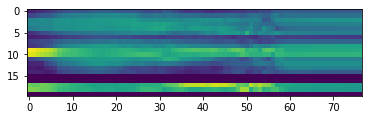

In [33]:
_plt.imshow(ddd[:, 0].T)

In [ ]:


outdir1     = datconf.getResultFN(dataset, "%(dir)s" % {"dir" : dat})
if not os.acc 
     os.mkdir(outdir1)
outdir     = datconf.getResultFN(dataset, "%(dir)s/v%(av)d%(gv)d" % {"dir" : dat, "av" : armv_ver, "gv" : gcoh_ver})
if not os.access(outdir, os.F_OK):
     os.mkdir(outdir)
#  12.10.2020
################  egenvectors
#imag_evs  = A_gcoh_mat["VEC"][0]


imag_evs  = lm["VEC"][strt:, :, ev_n]

L_gcoh  = A_gcoh.shape[0]
nChs    = imag_evs.shape[2]
real_evs  = _N.empty((L_gcoh, n_fs.shape[0], nChs))

chs = lm["chs_picks"]
ch_names = arr_ch_names[chs].tolist()

for ti in range(L_gcoh):
    real_evs[ti] = _N.abs(imag_evs[ti])

mn = _N.mean(real_evs, axis=0)
sd = _N.std(real_evs, axis=0)

fs = lm["fs"]


#frngs = [[12, 18], [20, 25], [28, 35], [38, 45]]
#frngs = [[12, 18], [20, 25], [28, 35], [35, 42], [38, 45]]
#frngs = [[10, 15]]
#frngs = [[10, 18]]
#frngs = [[12, 18]]
#frngs = [[10, 15], [20, 25], [30, 40]]
#frngs = [[18, 25]]
frngs = [[15, 25]]
#frngs = [[35, 42]]

#frngs = [[25, 35]]
#frngs = [[43, 49]]
#frngs = [[40, 50]]
#frngs = [[30, 45]]
#frngs = [[38, 50]]
#frngs = [[32, 48]]
#frngs = [[35, 47]]
#frngs = [[8, 12], [12, 18]]
#frngs = [[33, 40], [34, 41], [35, 42], [36, 43], [37, 44]]
#frngs = [[12, 18], [18, 25], [25, 35], [35, 45]]
#frngs = [[22, 28], [35, 42]]
#frngs = [[28, 35], [38, 45]]

ignore_stored = True
pcs     = _N.empty(len(frngs))
minK    =11
maxK    =12
#minK = 6
#maxK = 7
try_Ks  = _N.arange(minK, maxK+1)
#TRs      = _N.array([1, 1, 3, 5, 10, 15, 20, 25, 25])  # more tries for higher K
TRs      = _N.array([1, 15, 20, 25, 25, 30, 40, 50, 60, 60, 60, 60, 60, 60, 80, 80, 80, 80])  # more tries for higher K
#TRs      = _N.array([60])  # more tries for higher K

bics = _N.ones(((maxK-minK), _N.max(TRs)))*1000000
labs = _N.empty((maxK-minK, _N.max(TRs), real_evs.shape[0]), dtype=_N.int)

nState_start = 0

for ich in range(len(frngs)):
    fL = frngs[ich][0]
    fH = frngs[ich][1]

    irngs = _N.where((fs > fL) & (fs < fH))[0]
    iL    = irngs[0]
    iH    = irngs[-1]    

    #Apr242020_16_53_03_gcoh_256_64
    nStates, rmpd_lab = find_or_retrieve_GMM_labels(dataset, dat, "%(gf)s_gcoh%(evn)d_%(wn)d_%(sld)d_v%(av)d%(gv)d" % {"gf" : dat, "av" : armv_ver, "gv" : gcoh_ver, "wn" : win, "sld" : slideby, "evn" : ev_n}, real_evs, iL, iH, fL, fH, armv_ver, gcoh_ver, which=0, try_K=try_Ks, TRs=TRs, ignore_stored=ignore_stored, manual_cluster=manual_cluster, do_pca=True, min_var_expld=0.99)
    ps = _N.arange(nStates)
    ps += nState_start
    nState_start += nStates

    #nStates, rmpd_lab = find_or_retrieve_GMM_labels(rpsm[dat], "%(dat)s_gcoh_%(w)d_%(s)d" % {"dat" : dat, "w" : bin, "s" : slide}, real_evs, iL, iH, fL, fH, which=0, try_K=try_Ks, TRs=TRs, log_transform=False)
    """
    ###############
    for K in range(minK, maxK):
        for tr in range(TRs[K]):
            gmm = mixture.GaussianMixture(n_components=K, covariance_type="full")

            gmm.fit(_N.sum(real_evs[:, iL:iH], axis=1))
            bics[K-minK, tr] = gmm.bic(_N.sum(real_evs[:, iL:iH], axis=1))
            labs[K-minK, tr] = gmm.predict(_N.sum(real_evs[:, iL:iH], axis=1))

    coords = _N.where(bics == _N.min(bics))
    print("min bic %.4e" % _N.min(bics))
    bestLab = labs[coords[0][0], coords[1][0]]   #  indices in 2-D array
    rmpd_lab = increasing_labels_mapping(bestLab)

    nStates =  list(range(minK, maxK))[coords[0][0]]
    """
    out_u = _N.mean(real_evs[:, iL:iH], axis=1)
    out = _N.empty((L_gcoh, nChs))
    iS  = 0
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        out[iS:iS+len(ls)] = _N.mean(real_evs[ls, iL:iH], axis=1)
        iS += len(ls)

    iS = 0
    clrs  = ["black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red", "black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red"]
    W   = L_gcoh
    H   = nChs
    disp_wh_ratio = 3
    aspect = (W/H)/disp_wh_ratio
    unit = 2.5
    fig = _plt.figure(figsize=(disp_wh_ratio*unit + 1, 3*unit+unit/2))
    _plt.subplot2grid((2, 1), (0, 0))        
    _plt.title("1st GCoh eigenvector - temporal order")
    #fig.add_subplot(nStates+2, 1, 1)  
    _plt.imshow(out_u.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        nsx = _N.where(rmpd_lab == ns)[0]
        _plt.scatter(nsx, _N.ones(len(nsx))*ns - nStates - 1, color=clrs[ns], lw=1.5, s=4)
    _plt.xlim(0, L_gcoh)
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("time bin", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)

    _plt.subplot2grid((2, 1), (1, 0))        
    _plt.title("1st GCoh eigenvector - reordered by cluster label")
    #fig.add_subplot(nStates+2, 1, 1)    
    _plt.imshow(out.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        liS = iS
        iS += len(ls)
        _plt.plot([liS, iS], [ns-nStates-1, ns-nStates-1], color=clrs[ns], lw=3.5)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    _plt.xlim(0, L_gcoh)
    _plt.suptitle("%(ky)s   %(1)d-%(2)dHz    GCoh val: %(gcoh).3f   %(sts)s" % {"1" : fL, "2" : fH, "gcoh" : _N.mean(lm["Cs"][:, irngs]), "ky" : dat, "sts" : str(ps)})
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("time bin", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)

    iS = 0
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        iS += len(ls)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, hspace=0.3)

    _plt.savefig("%(od)s/%(dat)s_%(w)d_%(sl)d_clusters_coh_pattern_%(evn)d_%(1)d_%(2)d_v%(av)d%(gv)d" % {"1" : fL, "2" : fH, "dat" : dat, "w" : win, "sl" : slideby, "od" : outdir, "av" : armv_ver, "gv" : gcoh_ver, "evn" : ev_n}, transparent=True)
    #_plt.close()

    max_over_fs_each_state = _N.empty((nChs, nStates))
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        mn_over_fs = _N.mean(real_evs[ls, iL:iH], axis=1)
        #min_all    = _N.min(mn_over_fs, axis=0)
        max_over_fs_each_state[:, ns]    = _N.max(mn_over_fs, axis=0)
    maxComp = _N.max(max_over_fs_each_state)

    all_vecs = _N.empty((nChs, nStates))
    
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        mn_over_fs = _N.mean(real_evs[ls, iL:iH], axis=1)
        min_all    = _N.min(mn_over_fs, axis=0)
        all_vecs[:, ns] = (min_all / maxComp)*1e-5
    _sp.do_skull_plot_all_EVs(all_vecs, ps, ch_names, "%(od)s/%(dat)s_%(w)d_%(sl)d_skull_coh_pattern_%(evn)d_%(1)d_%(2)d_v%(av)d%(gv)d" % {"1" : fL, "2" : fH, "dat" : dat, "w" : win, "sl" : slideby, "av" : armv_ver, "gv" : gcoh_ver, "od" : outdir, "evn" : ev_n}, dat, fL, fH)

    sts = _N.zeros(real_evs.shape[0])
    fig = _plt.figure(figsize=(12, 3))

    SHUFFLES = 100
    maxlags=150
    acfs     = _N.empty((SHUFFLES+1, maxlags*2+1))
    shf_rmpd_lab = _N.empty((SHUFFLES+1, rmpd_lab.shape[0]), dtype=_N.int)
    shf_rmpd_lab[0] = rmpd_lab
    
    for shf in range(1, SHUFFLES+1):
         rl = shift_correlated_shuffle(rmpd_lab, low=hlfOverlap, high=(hlfOverlap*3), local_shuffle=True, local_shuffle_pcs=6)
         #rl = shift_correlated_shuffle(rmpd_lab, low=1, high=2, local_shuffle=True, local_shuffle_pcs=6)
         shf_rmpd_lab[shf] = rl

    for ns in range(nStates):
        _plt.subplot2grid((1, nStates), (0, ns))

        for hlvs in range(2):
            t0 = hlvs*(L_gcoh//2)
            t1 = (hlvs+1)*(L_gcoh//2)
            for shf in range(SHUFFLES+1):
                sts[:]=0
                sts[_N.where(shf_rmpd_lab[shf] == ns)[0]] = 1
                #_plt.acorr(sts - _N.mean(sts), maxlags=150, usevlines=False, ms=2, color=clr, lw=lw)
                acfs[shf] = autocorrelate(sts[t0:t1] - _N.mean(sts[t0:t1]), maxlags)
                acfs[shf, maxlags] = 0
            sACFS = _N.sort(acfs[1:], axis=0)
            _plt.plot(_N.arange(-maxlags, maxlags+1), acfs[0] + (1-hlvs)*0.7, color="black", lw=2)
            _plt.fill_between(_N.arange(-maxlags, maxlags+1), sACFS[int(SHUFFLES*0.025)] + 0.7*(1-hlvs), sACFS[int(SHUFFLES*0.975)] + 0.7*(1-hlvs), alpha=0.3, color="blue")

            #_plt.xticks([-(Fs/slideby)*15, -(Fs/slideby)*10, -(Fs/slideby)*5, 0, (Fs/slideby)*5, (Fs/slideby)*10, (Fs/slideby)*15], [-15, -10, -5, 0, 5, 10, 15], fontsize=15)   #stroop
            #_plt.xticks([-(Fs/slideby)*45, -(Fs/slideby)*30, -(Fs/slideby)*15, 0, (Fs/slideby)*15, (Fs/slideby)*30, (Fs/slideby)*45], [-45, -30, -15, 0, 15, 30, 45], fontsize=15)   #RPS
            _plt.xticks([-(Fs/slideby)*30, -(Fs/slideby)*20, -(Fs/slideby)*10, 0, (Fs/slideby)*10, (Fs/slideby)*20, (Fs/slideby)*30], [-30, -20, -10, 0, 10, 20, 30], fontsize=15)   #RPS
            _plt.yticks(fontsize=14)
            #_plt.ylim(-0.08, 0.2)
            _plt.ylim(-0.08, 1.4)
            #_plt.xlim(-(Fs/slideby)*15, (Fs/slideby)*15)    #  Stroop
            #_plt.xlim(-(Fs/slideby)*50, (Fs/slideby)*50)    #  RPS
        _plt.xlim(-(Fs/slideby)*30, (Fs/slideby)*30)    #  RPS
        _plt.grid(ls=":")
        _plt.xlabel("lag (seconds)", fontsize=16)
        _plt.ylabel("autocorrelation", fontsize=16)
        _plt.title("pattern %d" % ns)
    _plt.suptitle("%(1)d-%(2)dHz" % {"1" : fL, "2" : fH})
    fig.subplots_adjust(left=0.15, bottom=0.2, wspace=0.4, right=0.98, top=0.9)
    #_plt.savefig("%(od)s/%(dat)s_%(w)d_%(sl)d_acorr_%(evn)d_%(1)d_%(2)d_v%(av)d%(gv)d" % {"1" : fL, "2" : fH, "dat" : dat, "w" : win, "sl" : slideby, "av" : armv_ver, "gv" : gcoh_ver, "od" : outdir, "evn" : ev_n}, transparent=True)

